# Optimal Generator Dispatch

## 1 - Problem Description

Transmission system operators around the world typically employ some form of mathematical programming to plan and operate power grids. In the United Kingdom, each day is split into six discrete 4-hour blocks, called *Electricity Forward Agreement* (EFA) blocks, each with an anticipated total demand. In this problem, you will determine which of the available generator units should be dispatched to meet said demand in each of the EFA blocks so as to minimize total costs. In addition, you must consider the necessity for a reserve capacity, that is, the chosen units need the capability to increase their output while still adhering to their specified operating limits. This is essential to handle a situation where real demand surpasses anticipated demand.

## 2 - Available Data
Several files are available that contain the required the data to formulate the problem:
- Anticipated demand in each EFA block: `./demand.csv`
- Generator unit types, number of each type available and the operating limits of each: `./generators.csv`
- The costs associated with each generator unit type, including a fixed base cost for running the unit (GBP), a marginal cost for generation above its minimum output (GBP/MW), and a fixed start up cost for switching a generator unit on (GBP): `./costs.csv`

To consider reserve, assume the set of dispatched generator units should be able to produce 115% of predicted demand. Assume that there are already 5 generator units of each type running before the start of the first EFA block.

## 3 - Problem Formulation

### 3.1 - Decision Variables
- Number of generator units of type $t$ that are on during EFA block $b$: $N^{\text{gen}}_{t,b}$
- Power output from all generators of type $t$ during time period $p$: $P_{t,b}$
- Number of generators of type $t$ that startup in EFA block $b$: $N^{\text{startups}}_{t,b}$

### 3.2 - Objective

\begin{equation}
\textbf{minimize} 
\sum_{t, b}{C^{\textrm{base}}_t* N^{\text{gen}}_{t,b}} + \sum_{t, b}{C^{\text{running}}_t*(P_{t,b} - P^{\text{min}}_t}) + \sum_{t, b}{C^{\text{startup}}_t* N^{\text{startups}}_{t,b}}
\end{equation}

### 3.3 - Constraints
- The power output of each generator unit must satisfy the specified operating limits.
- In each EFA block, the dispatched generator units must not violate reserve requirements.
- The dispatched generator units must also provide enough power to satisfy the anticipated demand.
- The total number of generator units on during each EFA block cannot exceed the number available.

## 4 - Tasks
1. Import the required data.
2. Complete the mathematical formulation and implement the corresponding program in Python with Gurobi.
3. Evaluate the following:
    - The total cost of satisyfing the anticipated demand.
    - In each EFA block, the number of generator units that are active, as well as the number that must be switched on.

## 5 - Solution

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gurobipy as gp
from gurobipy import GRB

%matplotlib inline
%config InlineBackend.figure_format = "svg"

### 5.1 - Load Data

In [3]:
costs = pd.read_csv("./docs/costs.csv")
demand = pd.read_csv("./docs/demand.csv")
generators = pd.read_csv("./docs/generators.csv")

# Data shape:
#costs = {
#    "base": [1000, 2600, 3000],
#    "running": [2, 1.3, 3],
#    "startup": [2000, 1000, 500]
#}

#demand = {
#    "power": [15000, 30000, 25000, 25000, 40000, 27000],
#    "efa_block": [1, 2, 3, 4, 5, 6]
#}

#generators = {
#    "type": [1, 2, 3],
#    "num_generators": [12, 10, 5],
#    "min_power": [850, 1250, 1500],
#    "max_power": [2000, 1750, 4000]
#}

In [6]:
costs

,base,running,startup
0,1000,2.0,2000
1,2600,1.3,1000
2,3000,3.0,500


In [7]:
demand

,power,efa_block
0,15000,1
1,30000,2
2,25000,3
3,25000,4
4,40000,5
5,27000,6


In [8]:
generators

,type,num_generators,min_power,max_power
0,1,12,850,2000
1,2,10,1250,1750
2,3,5,1500,4000


### 5.2 - Set Parameters

In [5]:
num_blocks = len(demand) # Number of EFA blocks
num_types = len(generators) # Number of generator unit types
block_hours = [4, 4, 4, 4, 4, 4] # Hours in each EFA block
num_generators_init = 5 # Initial number of generator units running of each type
reserve_requirement = 1.15 # Additional capacity required for reserve

### 5.3 - Build Model

In [ ]:
#with gp.Env() as env, gp.Model(env=env) as model:

model = gp.Model()

#############################################
# 1. First we define the decision variables #
#############################################

# Number of generator units of each type running during each EFA block
num_generators = model.addVars(
    num_types, num_blocks, vtype=GRB.INTEGER, name="num_generators"
    # NOTE: limits can be set directly in variable definition using "ub" and "lb" arguments e.g. ub=10
)
# NOTE: by default, gurobipy variables are non-negative (i.e., >= 0

# Number of generator units started up for each EFA block.
num_startups = model.addVars(
    num_types, num_blocks, vtype=GRB.INTEGER, name="num_startups"
)

# Power output of each generator type during each EFA block.
power_output = model.addVars(
    num_types, num_blocks, vtype=GRB.CONTINUOUS, name="power_output"
)

######################################
# 2. Next we specify the constraints #
######################################

# The power output of each generator unit must satisfy the specified operating limits.
model.addConstrs(
    (
        power_output[t, b]
        >= generators["min_power"][t] * num_generators[t, b]
    )
    for t in range(num_types)
    for b in range(num_blocks)
)
model.addConstrs(
    (
        power_output[t, b]
        <= generators["max_power"][t] * num_generators[t, b]
    )
    for t in range(num_types)
    for b in range(num_blocks)
)

# In each EFA block, the dispatched generator units must not violate reserve requirements.
model.addConstrs(
    gp.quicksum(
        generators["max_power"][t] * num_generators[t, b]
        for t in range(num_types)
)
    >= (reserve_requirement * demand["power"][b])
    for b in range(num_blocks)
)

# The dispatched generator units must also provide enough power to satisfy the anticipated demand.
model.addConstrs(
    gp.quicksum(power_output[t, p] for t in range(num_types))
    >= demand["power"][p]
    for p in range(num_blocks)
)

# The total number of generator units on during each EFA block cannot exceed the number available.
model.addConstrs(
    num_generators[t, b] <= generators["num_generators"][t]
    for t in range(num_types)
    for b in range(num_blocks)
)

# Increasing generator numbers requires a num_startups action.
model.addConstrs(
    (num_generators[t, b] <= num_generators[t, b - 1] + num_startups[t, b])
    for t in range(num_types)
    for b in range(1, num_blocks)
)

# Specifying that at t-1 there were num_generators_init running units of each type.
model.addConstrs(
    (num_generators[t, 0] <= num_generators_init + num_startups[t, 0])
    for t in range(num_types)
)

###########################################
# 3. Lastly we set the objective function #
###########################################

model.setObjective(
    gp.quicksum(
        costs["base"][t] * block_hours[b] * num_generators[t, b]
        for t in range(num_types)
        for b in range(num_blocks)
)
    + gp.quicksum(
        costs["running"][t]
        * block_hours[b]
        * (
            power_output[t, b]
            - generators["min_power"][t] * num_generators[t, b]
        )
        for t in range(num_types)
        for b in range(num_blocks)
)
    + gp.quicksum(
        costs["startup"][t] * num_startups[t, b]
        for t in range(num_types)
        for b in range(num_blocks)
)
, sense=GRB.MINIMIZE #NOTE: Gurobipy defaults to minimization, this line can be optionally included for clarity, and must be changed if maximizing
)

model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 5 135U, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 14 logical processors, using up to 14 threads

CPU model: Intel(R) Core(TM) Ultra 5 135U, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 14 logical processors, using up to 14 threads

Academic license 2703143 - for non-commercial use only - registered to s2___@student.dtu.dk
Optimize a model with 84 rows, 54 columns and 177 nonzeros
Model fingerprint: 0xa830ee85
Variable types: 18 continuous, 36 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [5e+00, 6e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 5e+04]

Academic license 2703143 - for non-commercial use only - registered to s2___@student.dtu.dk
Optimize a model with 84 rows, 54 columns and 177 nonzeros
Model fingerprint: 0xa830ee85
Variable types: 18 continuous, 

### 5.4 - Results

1. The total cost of satisyfing the anticipated demand:

In [6]:
print(f"The total cost of satisfying the anticipated demand: GBP {model.ObjVal}")

The total cost of satisyfing the anticipated demand: GBP 1071660.0


2. In each EFA block, the number of generator units that are active, as well as the number that must be switched on.

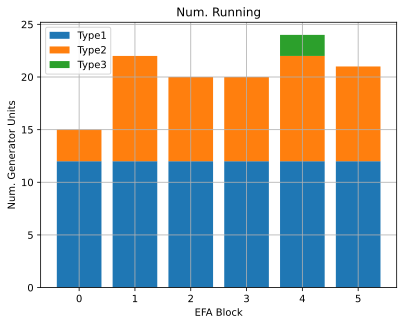

In [13]:
fig, ax = plt.subplots()
for i, b in enumerate(range(num_blocks)):
    bottom = 0
    for j, t in enumerate(range(num_types)):
        height = num_generators[t, b].x
        ax.bar(x=b, height=height, bottom=bottom, color=f"C{j}", label=f"Type{j+1}" if i == 0 else "")
        bottom += height
ax.set_xlabel("EFA Block")
ax.set_ylabel("Num. Generator Units")
ax.legend()
ax.set_title("Num. Running")
ax.grid(which="major")
plt.show()

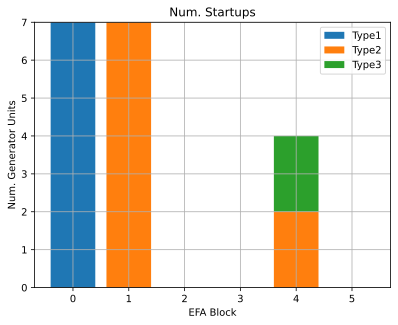

In [14]:
fig, ax = plt.subplots()
for i, b in enumerate(range(num_blocks)):
    bottom = 0
    for j, t in enumerate(range(num_types)):
        height = num_startups[t, b].x
        ax.bar(x=b, height=height, bottom=bottom, color=f"C{j}", label=f"Type{j+1}" if i == 0 else "")
        bottom += height
ax.set_xlabel("EFA Block")
ax.set_ylabel("Num. Generator Units")
ax.legend()
ax.grid(which="major")
ax.set_title("Num. Startups")
plt.show()